# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

In [50]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import scipy
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

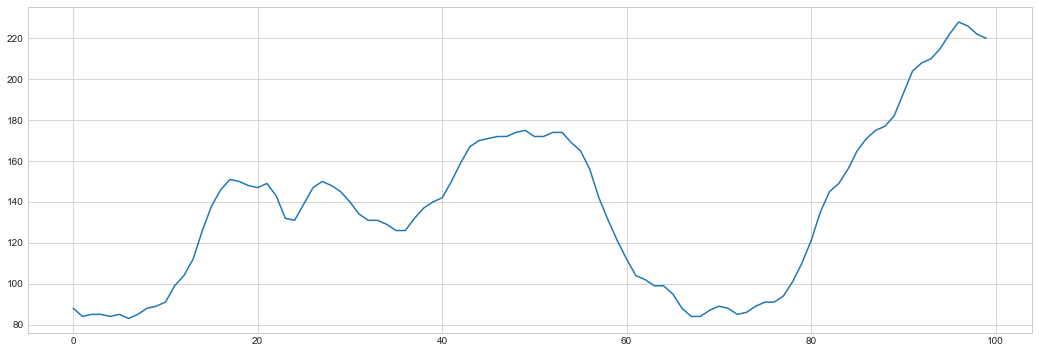

In [12]:
df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
#Affichage
plt.figure(figsize=(18,6))
plt.plot(df);

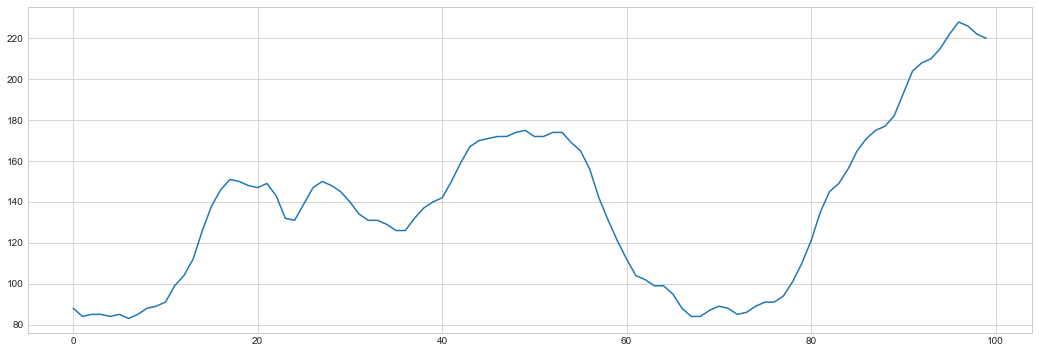

In [8]:
plt.figure(figsize=(18,6))
plt.plot(y);

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [5]:
from statsmodels.tsa.stattools import adfuller
adfuller(y)

(-2.4642397172033688,
 0.12441935447109453,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

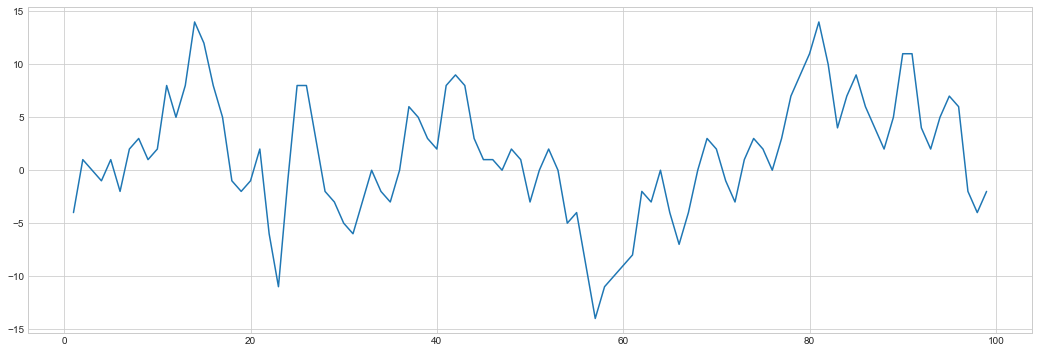

In [25]:
y_diff= y.diff()
plt.figure(figsize=(18,6))
plt.plot(y_diff);

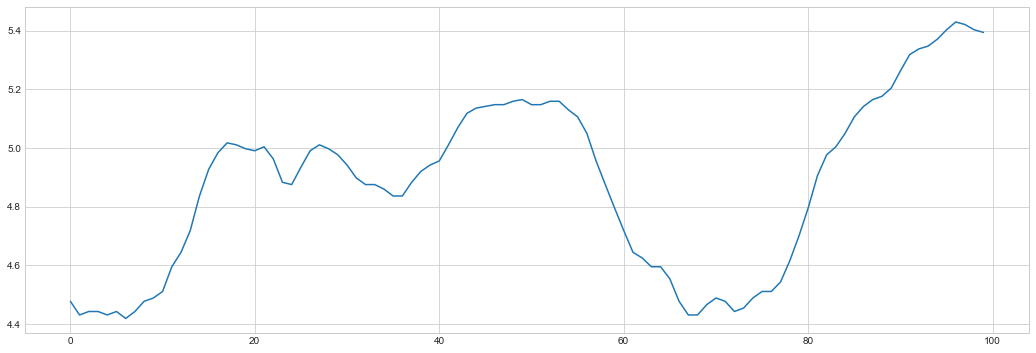

In [10]:
import numpy as np

df_log = np.log(y)
plt.figure(figsize=(18,6))
plt.plot(df_log);

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

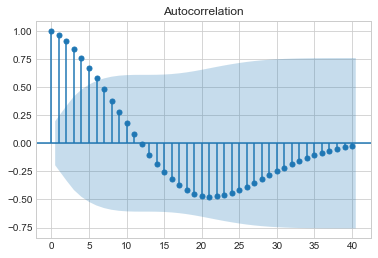

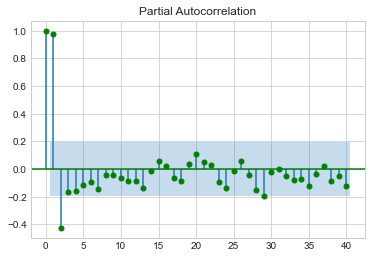

In [13]:
plot_acf(df_log, lags=40) 
plot_pacf(df_log, lags=40, color='g')
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [44]:
y_diff.isna().sum()

0

In [45]:
def get_stationarity(df_log):
    
    # Statistiques mobiles
    moyenne = y_diff.rolling(window=12).mean()
    ecart_type = y_diff.rolling(window=12).std()
    
    # tracé statistiques mobiles
    plt.figure(figsize=(18,6))
    original = plt.plot(df_log, color='blue', label='Origine')
    mean = plt.plot(moyenne, color='red', label='Moyenne Mobile')
    std = plt.plot(ecart_type, color='black', label='Ecart-type Mobile')
    #Affichage
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(y_diff)
    print(result)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

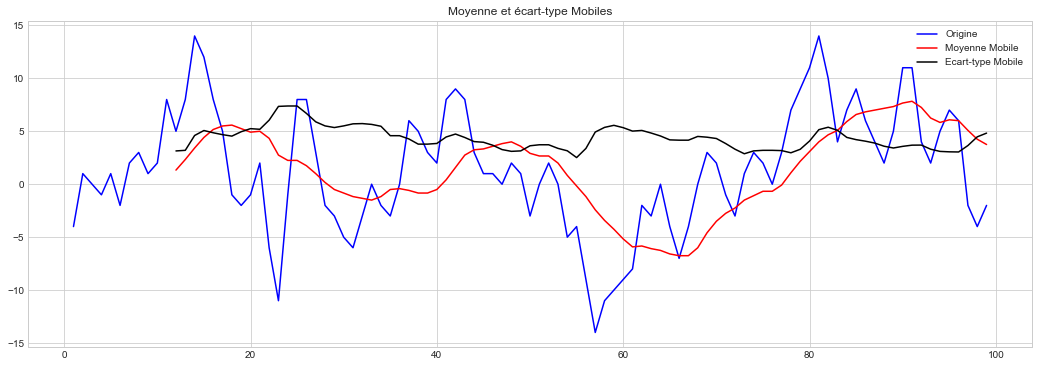

(-2.7222384904429533, 0.07026846015272693, 2, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 438.89606128026)
Statistiques ADF : -2.7222384904429533
p-value : 0.07026846015272693
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


In [46]:
get_stationarity(y_diff)

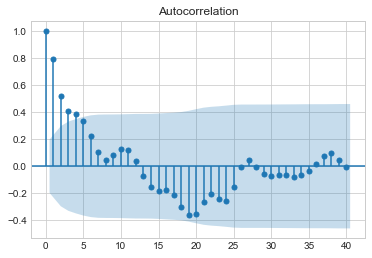

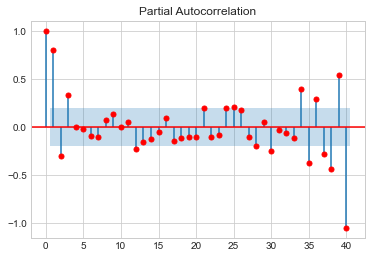

In [54]:
plot_acf(y_diff, lags=40) 
plot_pacf(y_diff, lags=40, color='r')
plt.show();

#Pour le normal q=1
#Pour le partiel p=1

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [57]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy
mod = sm.tsa.arima.ARIMA(y_diff, order=(2, 1, 4))
res = mod.fit()

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

In [58]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   99
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -250.088
Date:                Wed, 05 Jan 2022   AIC                            514.176
Time:                        11:07:55   BIC                            532.270
Sample:                             0   HQIC                           521.495
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2865      0.161     -7.975      0.000      -1.603      -0.970
ar.L2         -0.6987      0.115     -6.094      0.000      -0.923      -0.474
ma.L1          1.5394      0.209      7.377      0.0

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [59]:
mod = sm.tsa.arima.ARIMA(y_diff, order=(3, 1, 4))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   99
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -249.956
Date:                Wed, 05 Jan 2022   AIC                            515.913
Time:                        11:10:01   BIC                            536.593
Sample:                             0   HQIC                           524.278
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4278      0.501      0.853      0.393      -0.555       1.410
ar.L2          0.1436      0.298      0.481      0.630      -0.441       0.728
ar.L3          0.1758      0.264      0.666      0.5

In [60]:
mod = sm.tsa.arima.ARIMA(y_diff, order=(1, 0, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   99
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -253.790
Date:                Wed, 05 Jan 2022   AIC                            515.579
Time:                        11:10:57   BIC                            525.960
Sample:                             0   HQIC                           519.779
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1204      1.322      0.848      0.397      -1.470       3.711
ar.L1          0.6344      0.091      6.950      0.000       0.455       0.813
ma.L1          0.5297      0.090      5.907      0.0

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

In [61]:
mod = sm.tsa.arima.ARIMA(y_diff, order=(1, 1, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -258.796
Date:                Wed, 05 Jan 2022   AIC                            523.592
Time:                        11:12:44   BIC                            531.347
Sample:                             0   HQIC                           526.729
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2661      0.215     -1.238      0.216      -0.688       0.155
ma.L1          0.6139      0.169      3.635      0.000       0.283       0.945
sigma2        11.4929      1.666      6.897      0.0

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

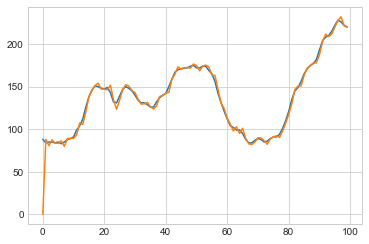

In [71]:
mod = sm.tsa.arima.ARIMA(y, order=(1, 1, 1))
res = mod.fit()
pred= res.predict()
plt.plot(y)
plt.plot(pred)


In [124]:
! pip install statsmodels --upgrade

In [ ]:
! pip uninstall statsmodels

In [ ]:
! pip install statsmodels==0.12.1

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

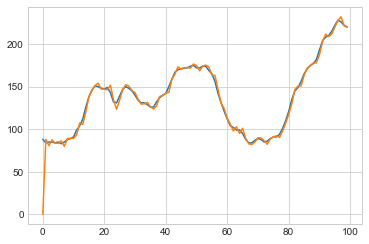

In [74]:
y_pred = res.predict(dynamic=False)
plt.plot(y);
plt.plot(y_pred);

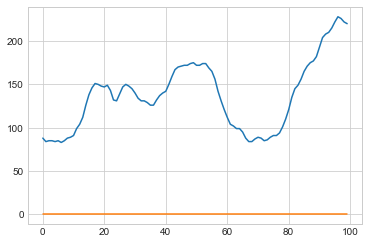

In [75]:
y_pred = res.predict(dynamic=True)
plt.plot(y);
plt.plot(y_pred);

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [97]:
#prevision
res.forecast(15)

100    218.880504
101    218.152418
102    217.678892
103    217.370924
104    217.170632
105    217.040367
106    216.955647
107    216.900548
108    216.864713
109    216.841407
110    216.826249
111    216.816391
112    216.809980
113    216.805810
114    216.803098
Name: predicted_mean, dtype: float64

In [93]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]


# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(15, alpha=0.05)  # 95% conf

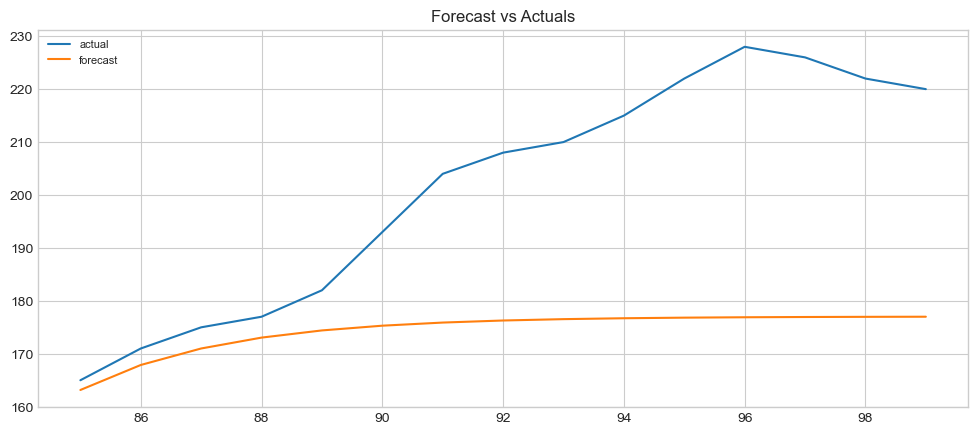

In [113]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

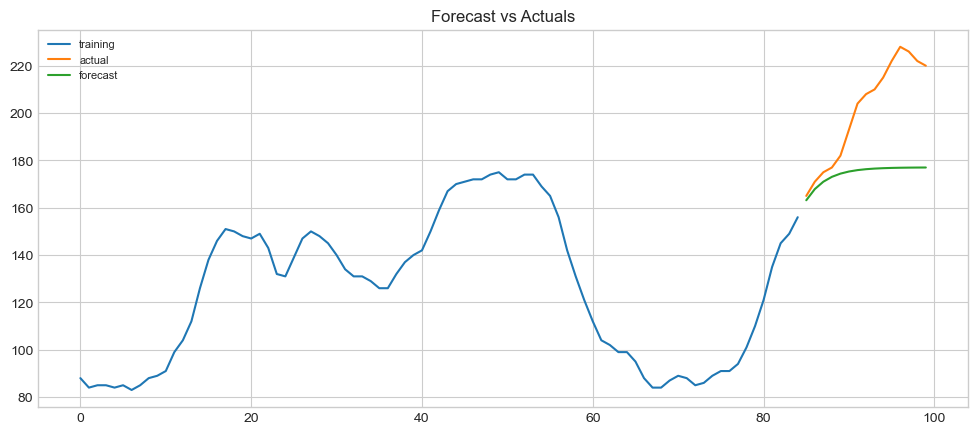

In [112]:
# Forecast
fc = fitted.forecast(15, alpha=0.05)  # 95% conf

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

In [105]:
fitted.resid

0     88.000000
1     -4.002382
2      4.223792
3     -2.420731
4      0.137725
        ...    
80     3.708440
81     4.942350
82    -1.635992
83    -1.802254
84     5.236596
Length: 85, dtype: float64

(array([53., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-8.61280206,  1.04847815, 10.70975835, 20.37103856, 30.03231876,
        39.69359897, 49.35487918, 59.01615938, 68.67743959, 78.33871979,
        88.        ]),
 <BarContainer object of 10 artists>)

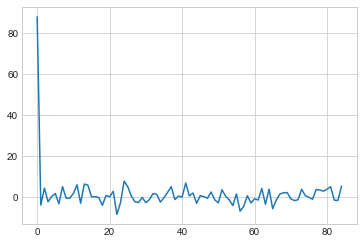

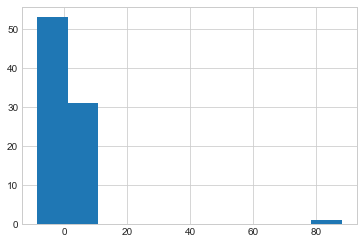

In [114]:
plt.plot(fitted.resid)
plt.figure()
plt.hist(fitted.resid)

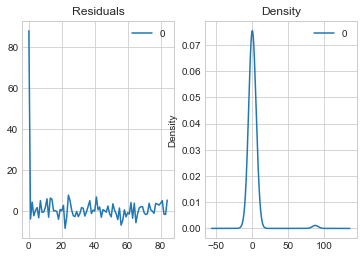

In [115]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [116]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [118]:
forecast_accuracy(fc, test)

{'mape': 0.12522186451638948,
 'me': -26.871495550124436,
 'mae': 26.871495550124436,
 'mpe': -0.12522186451638948,
 'rmse': 32.3823820968468,
 'acf1': 0.8714402846926663,
 'corr': 0.8528510972618887,
 'minmax': 0.1252218645163895}

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [120]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y,  start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

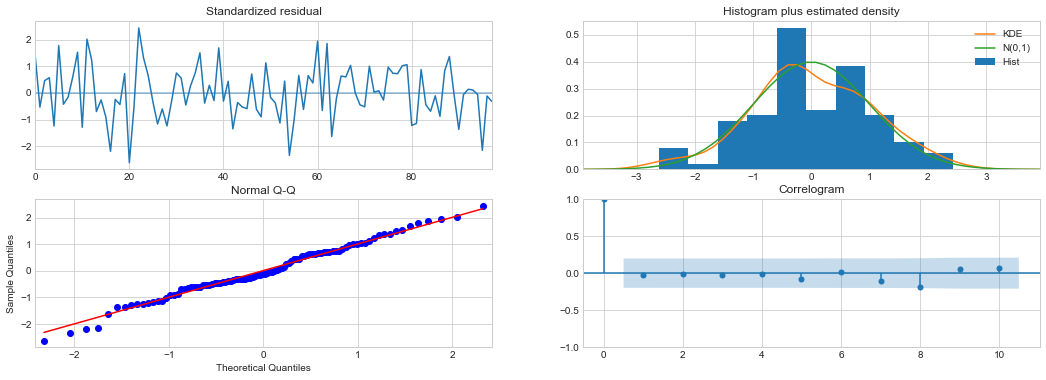

In [122]:
model.plot_diagnostics(figsize=(18,6))
plt.show()

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>